# Adevinta: Price similarity

Another way of looking for similarities that could interest to our customers is to look at similarities on prices.

Given a set of characteristics of the property try to infer the price range of such property and recommend to the users similar properties based on price.

To do so we're going to use regression models on "price".

**note:** because the differences on prices between selling and renting properties we've separated the problem into: sell price prediction and rent price prediction.

In [368]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [369]:
%matplotlib inline

In [426]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from joblib import dump, load

In [371]:
import statsmodels.api as sm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 

### Adevinta: Dataset loading (calculated in exploratory analysis)

The problem for regression on price purposed has been splitted between Sell and Rent properties.

Share properties have not been considered.

In [372]:
df_fotocasa = pd.read_pickle("./data/df_fotocasa.pkl")

In [373]:
df_fotocasa[["idproperty","transacion_type","price"]]\
    .groupby(["transacion_type"]).agg({
        'idproperty': pd.Series.nunique,
        'price': 'mean'
    })

,idproperty,price
transacion_type,,
Added in Olap,28,971.774194
Rent,176,4835.574297
Sell,880,310944.378115
Share,5,528.000000


In [374]:
def get_numerical_dataframe(df_fotocasa_):
    df_fotocasa_vars = \
        df_fotocasa_[['surface','rooms','baths',
                      'latitude','longitude','price',
                      'property_subtype']] \
            .groupby(['surface','rooms','baths','latitude',
                      'property_subtype','longitude']) \
            .max().reset_index()

    df_fotocasa_property_subtype = pd.get_dummies(df_fotocasa_vars.property_subtype)

    df_fotocasa_new = pd.concat([
        df_fotocasa_vars[['surface','rooms','baths',
            'latitude','longitude','price']], 
        df_fotocasa_property_subtype,
    ], axis=1,sort=False)
    return df_fotocasa_new

In [375]:
df_fotocasa_sell = pd.read_pickle("./data/df_fotocasa_sell.pkl")

In [376]:
df_fotocasa_sell_new = get_numerical_dataframe(df_fotocasa_sell)

df_fotocasa_sell_new = \
    df_fotocasa_sell_new[df_fotocasa_sell_new.price > 0.0].copy()

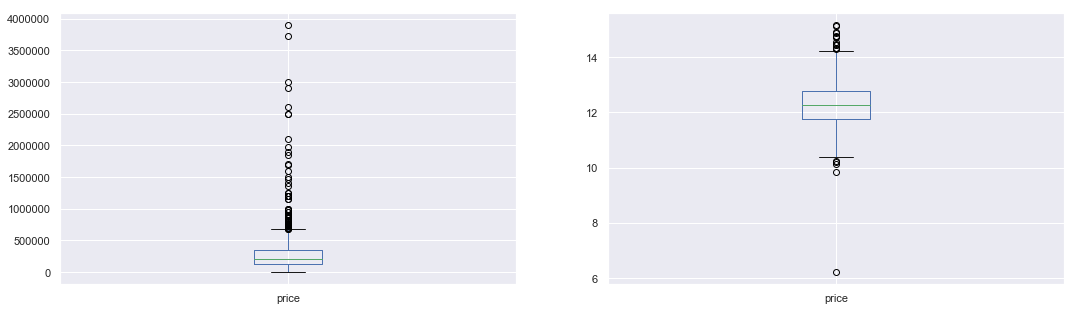

In [377]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
df_fotocasa_sell_new.price.plot('box', ax=ax1)
df_fotocasa_sell_new.price.apply(lambda x : np.log(x)).plot('box', ax=ax2)

In [378]:
df_fotocasa_sell_new['price_log'] = \
    df_fotocasa_sell_new.price.apply(lambda x : np.log(x))

In [379]:
print("\nObservations: {}, Features: {}\n".format(
    df_fotocasa_sell.shape[0], df_fotocasa_sell.shape[1]-1))


Observations: 923, Features: 9



In [380]:
df_fotocasa_rent = pd.read_pickle("./data/df_fotocasa_rent.pkl")

In [382]:
df_fotocasa_rent_new = get_numerical_dataframe(df_fotocasa_rent)

df_fotocasa_rent_new = \
    df_fotocasa_rent_new[df_fotocasa_rent_new.price > 0.0].copy()

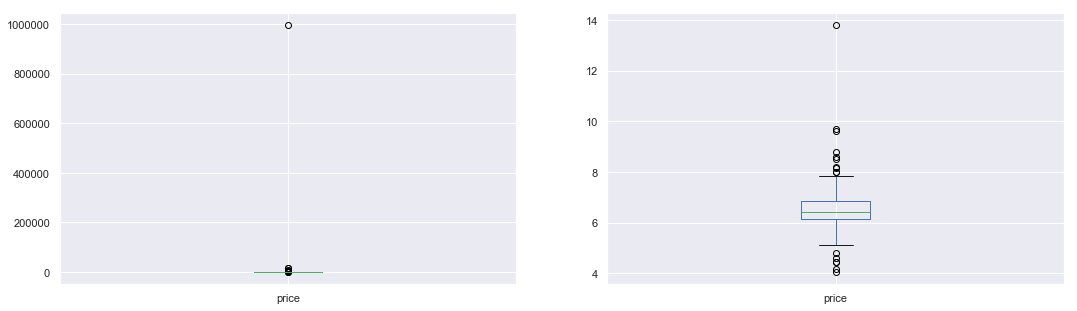

In [383]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
df_fotocasa_rent_new.price.plot('box', ax=ax1)
df_fotocasa_rent_new.price.apply(lambda x : np.log(x)).plot('box', ax=ax2)

In [384]:
df_fotocasa_rent_new['price_log'] = \
    df_fotocasa_rent_new.price.apply(lambda x : np.log(x))

In [385]:
print("\nObservations: {}, Features: {}\n".format(
    df_fotocasa_rent_new.shape[0], df_fotocasa_rent_new.shape[1]-1))


Observations: 161, Features: 15



## Adevinta: Feature engineering and selection

- Feature scaling (if needed)
- Feature selection: regression stepwise

**Feature scaling**

In [386]:
output = 'price_log'
features = [x for x in df_fotocasa_sell_new.columns if x != output]

In [387]:
y_sell = df_fotocasa_sell_new[[output]].astype("float")
X_sell = df_fotocasa_sell_new[features].astype("float")

In [388]:
X_sell_std = StandardScaler().fit_transform(X_sell)
y_sell_std = StandardScaler().fit_transform(y_sell)

X_sell_std = pd.DataFrame(X_sell_std)
X_sell_std.columns = X_sell.columns

In [307]:
output = 'price_log'
features = [x for x in df_fotocasa_rent_new.columns if x != output]

In [308]:
y_rent = df_fotocasa_rent_new[[output]].astype("float")
X_rent = df_fotocasa_rent_new[features].astype("float")

In [389]:
X_rent_std = StandardScaler().fit_transform(X_rent)
y_rent_std = StandardScaler().fit_transform(y_rent)

X_rent_std = pd.DataFrame(X_rent_std)
X_rent_std.columns = X_rent.columns

**Feature selection: regression stepwise and feature importance**

In [195]:
import statsmodels.api as sm

In [314]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.argmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [315]:
from sklearn.model_selection import train_test_split

**Sell properties**

In [390]:
X_sell_train, X_sell_test, y_sell_train, y_sell_test = \
    train_test_split(X_sell_std, y_sell_std, test_size=0.33, random_state=42)

In [391]:
result = stepwise_selection(X_sell_train, y_sell_train)

print('SELL: resulting features:')
print(result)

/Users/davidquer/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/davidquer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


Add  price                          with p-value 9.84155e-125
Add  baths                          with p-value 1.24018e-22
Add  Piso                           with p-value 6.34757e-05
SELL: resulting features:
['price', 'baths', 'Piso']


In [392]:
model = LassoCV()
model.fit(X_sell_train, y_sell_train)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" % model.score(X_sell,y_sell))
coef = pd.Series(model.coef_, index = X_sell_train.columns)

Best alpha using built-in LassoCV: 0.001753
Best score using built-in LassoCV: -128713590544.131302


/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [393]:
print("\nLasso picked " + str(sum(coef != 0)) + \
      " variables and eliminated the other " +  \
      str(sum(coef == 0)) + " variables\n")


Lasso picked 15 variables and eliminated the other 1 variables



Text(0.5, 1.0, 'Feature importance using Lasso Model')

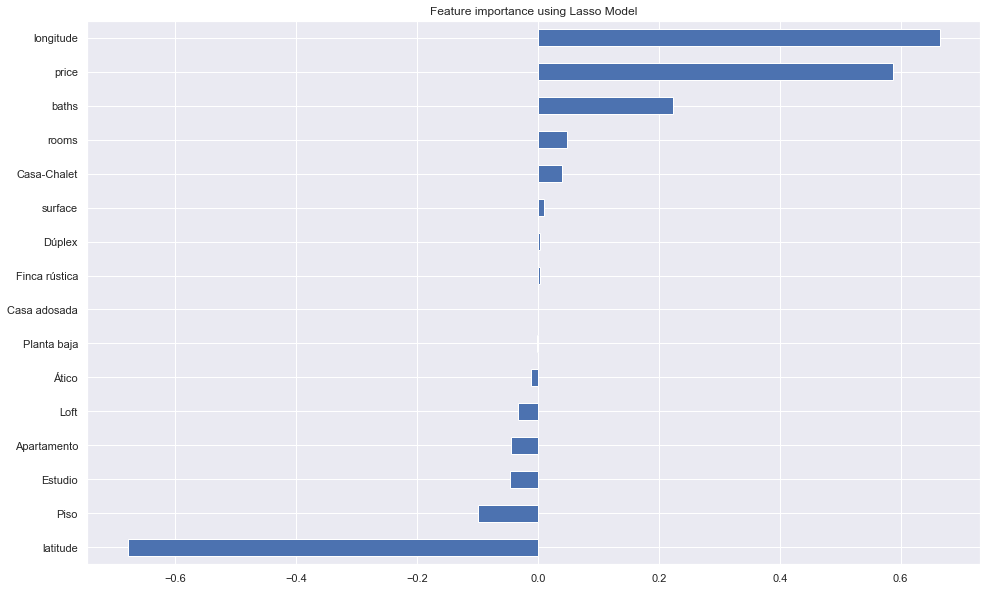

In [394]:
imp_coef = coef.sort_values()
ax = imp_coef.plot(kind = "barh", figsize=(16,10))
ax.set_title("Feature importance using Lasso Model")

In [396]:
sel_fea_sell = \
    ['surface', 'rooms', 'baths', 'latitude', 'longitude', 'price',
     'Apartamento', 'Casa-Chalet', 'Dúplex', 'Estudio',
     'Finca rústica', 'Loft', 'Piso', 'Planta baja', 'Ático']

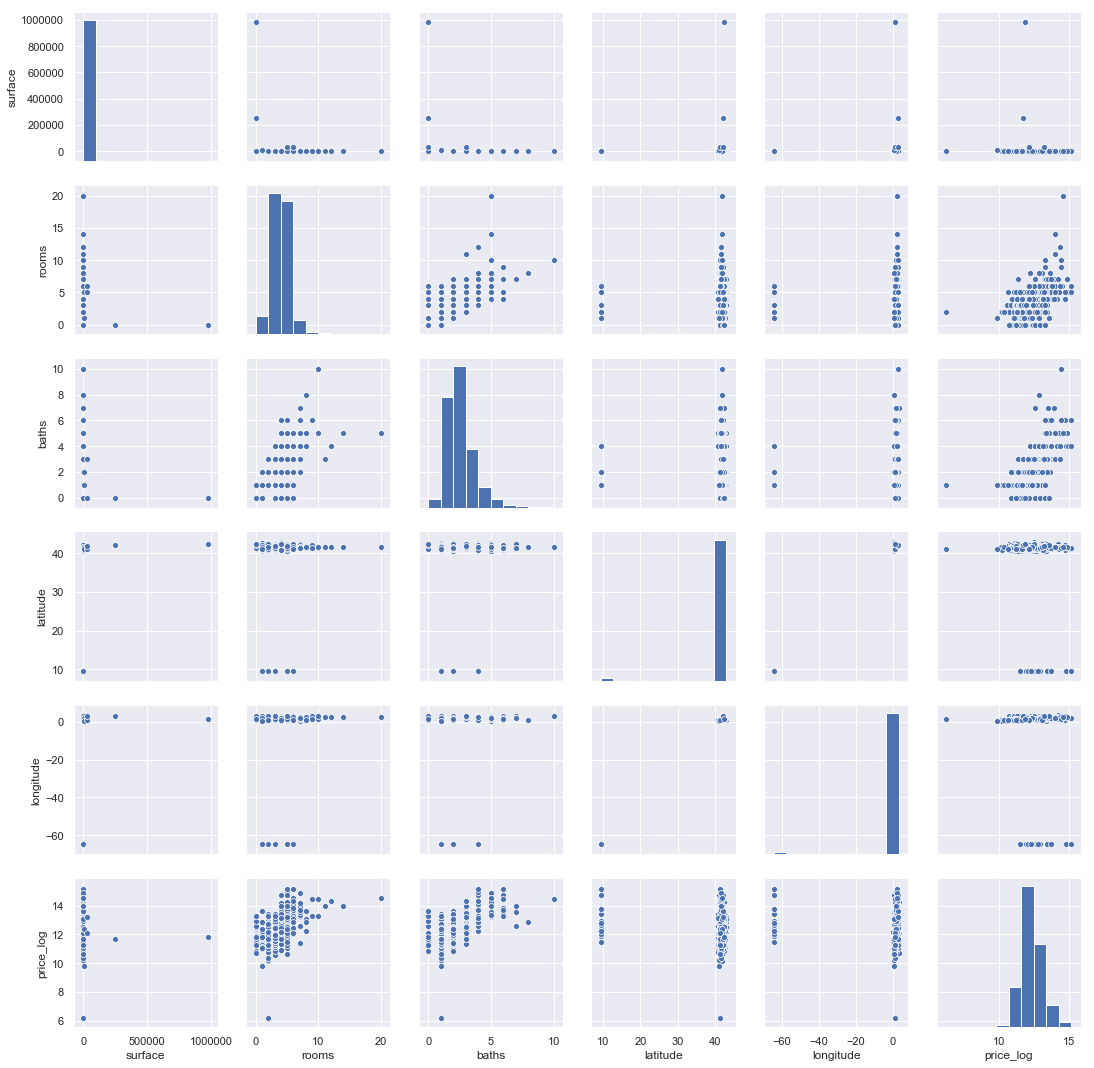

In [397]:
import seaborn as sns; sns.set()
sns.pairplot(df_fotocasa_sell_new[features[:5]+['price_log']])

**Rent properties**

In [398]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = \
    train_test_split(X_rent, y_rent, test_size=0.33, random_state=42)

In [399]:
result = stepwise_selection(X_rent_train, y_rent_train)

print('RENT: resulting features:')
print(result)

Add  baths                          with p-value 9.56412e-11
RENT: resulting features:
['baths']


/Users/davidquer/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/davidquer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


In [401]:
model = LassoCV()
model.fit(X_rent_train, y_rent_train)
print("Best alpha using built-in LassoCV: %f" % model.alpha_)
print("Best score using built-in LassoCV: %f" % model.score(X_rent,y_rent))
coef = pd.Series(model.coef_, index = X_rent_train.columns)

Best alpha using built-in LassoCV: 178.584199
Best score using built-in LassoCV: -0.003407


/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [402]:
print("\nLasso picked " + str(sum(coef != 0)) + \
      " variables and eliminated the other " +  \
      str(sum(coef == 0)) + " variables\n")


Lasso picked 3 variables and eliminated the other 11 variables



Text(0.5, 1.0, 'Feature importance using Lasso Model')

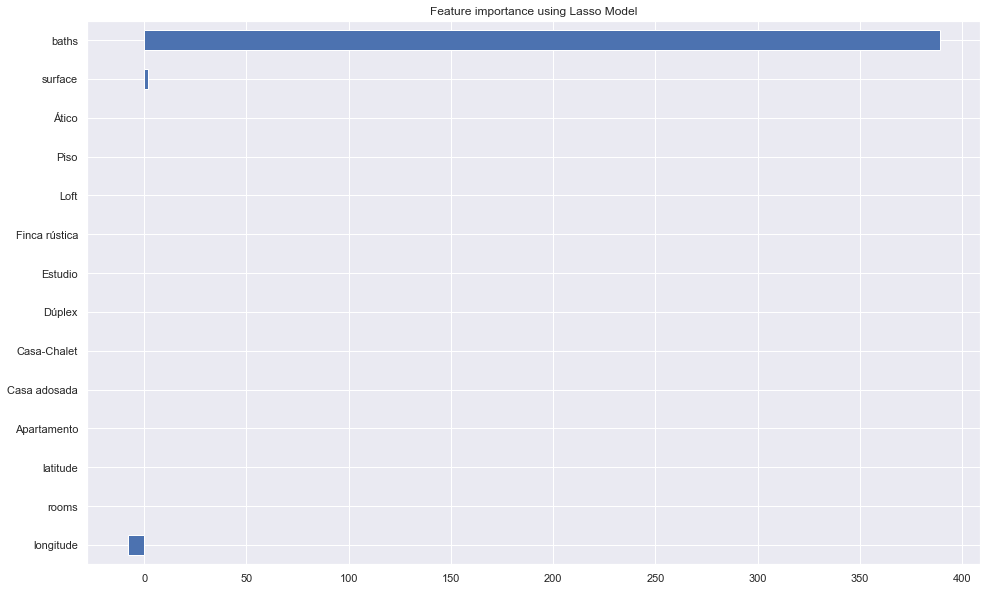

In [403]:
imp_coef = coef.sort_values()
ax = imp_coef.plot(kind = "barh", figsize=(16,10))
ax.set_title("Feature importance using Lasso Model")

In [404]:
sel_fea_rent = ['baths','surface','longitude']

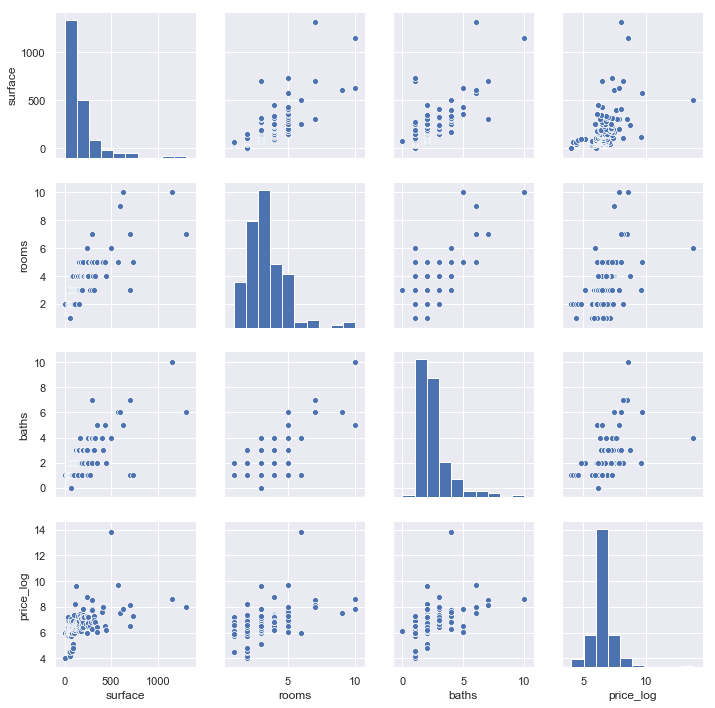

In [405]:
import seaborn as sns; sns.set()
sns.pairplot(df_fotocasa_rent_new[features[:3]+['price_log']])

## Adevinta: Model fitting (Sell properties)

### Adevinta: Model fitting and evaluation: Linear regression

**Sell prediction**

In [362]:
y_sell = df_fotocasa_sell_new[[output]].astype("float")
X_sell = df_fotocasa_sell_new[sel_fea_sell].astype("float")

In [363]:
X_sell_train, X_sell_test, y_sell_train, y_sell_test = \
    train_test_split(X_sell, y_sell, test_size=0.33, random_state=42)

In [364]:
model_11 = sm.OLS(y_sell_train, X_sell_train).fit()
model_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.957e+04
Date:                Sun, 27 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:24:49   Log-Likelihood:                -529.74
No. Observations:                 578   AIC:                             1083.
Df Residuals:                     566   BIC:                             1136.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
surface        1.899e-07   6.39e-07      0.297      0.767   -1.07e-06    1.45e-06
rooms             0.0908      0.022      4.194      0.000       0.048       0.133
baths             0.3330      0.029     11.369      0.000       0.275       0.391
latitude          0.2743      0.004     72.064      0.000       0.267       0.282
longitude        -0.1435      0.003    -42.594      0.000      -0.150      -0.137
Apartamento       0.0525      0.178      0.295      0.768      -0.297       0.401
Casa adosada      0.0607      0.163      0.372      0.710      -0.260       0.381
Casa-Chalet       0.3047      0.159      1.920      0.055      -0.007       0.616
Dúplex           -0.0602      0.202     -0.298      0.766      -0.457       0.336
Finca rústica     0.2822      0.185      1.524      0.128      -0.082       0.646
Loft             -0.4304      0.388     -1.110      0.268      -1.192       0.331
Piso             -0.0243      0.157     -0.155      0.877      -0.333       0.284
==============================================================================
Omnibus:                      211.083   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2842.624
Skew:                          -1.218   Prob(JB):                         0.00
Kurtosis:                      13.588   Cond. No.                     7.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [365]:
y_pred_11 = model_11.predict(X_sell_test)

In [366]:
MAE = mean_absolute_error(y_sell_test, y_pred_11)
print('Linear regression validation MAE = ', MAE)

Linear regression validation MAE =  0.42065625910892385


In [406]:
np.exp(0.42065625910892385)

1.5229606845608166

**Rent prediction**

In [407]:
y_rent = df_fotocasa_rent_new[[output]].astype("float")
X_rent = df_fotocasa_rent_new[sel_fea_rent].astype("float")

In [408]:
X_rent_train, X_rent_test, y_rent_train, y_rent_test = \
    train_test_split(X_rent, y_rent, test_size=0.33, random_state=42)

In [409]:
model_12 = sm.OLS(y_rent_train, X_rent_train).fit()
model_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     87.25
Date:                Sun, 27 Oct 2019   Prob (F-statistic):           2.77e-28
Time:                        13:37:49   Log-Likelihood:                -286.33
No. Observations:                 107   AIC:                             578.7
Df Residuals:                     104   BIC:                             586.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
baths          2.2644      0.255      8.863      0.000       1.758       2.771
surface       -0.0015      0.002     -0.623      0.535      -0.006       0.003
longitude     -0.0363      0.031     -1.153      0.251      -0.099       0.026
==============================================================================
Omnibus:                       61.887   Durbin-Watson:                   1.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.780
Skew:                          -2.059   Prob(JB):                     2.09e-50
Kurtosis:                       8.862   Cond. No.                         206.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [410]:
y_pred_12 = model_12.predict(X_rent_test)

In [411]:
MAE = mean_absolute_error(y_rent_test, y_pred_12)
print('Linear regression validation MAE = ', MAE)

Linear regression validation MAE =  2.946751360601485


In [412]:
np.exp(2.946751360601485)

19.043986083967972

### Adevinta: Model fitting and evaluation: Random forest regressor

**Sell prediction**

In [413]:
model_ = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 500, 1000],
}
model_21 = GridSearchCV(model_, parameters, cv=2, verbose=2, n_jobs=-1)

In [414]:
model_21.fit(X_sell_train, y_sell_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    3.0s finished
/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [415]:
y_pred_21 = model_21.predict(X_sell_test)

In [416]:
MAE = mean_absolute_error(y_sell_test, y_pred_21)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.009875805096108733


In [425]:
np.exp(0.009875805096108733)

1.009924731790115

In [428]:
dump(model_21, './models/model_21_sell_randomForest.joblib') 

['./models/model_21_sell_randomForest.joblib']

**Rent prediction**

In [417]:
model_ = RandomForestRegressor()
parameters = {
    'n_estimators': [100, 500, 1000],
}
model_22 = GridSearchCV(model_, parameters, cv=2, verbose=2, n_jobs=-1)

In [418]:
model_22.fit(X_rent_train, y_rent_train)

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.9s finished
/Users/davidquer/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:740: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [419]:
y_pred_22 = model_22.predict(X_rent_test)

In [423]:
MAE = mean_absolute_error(y_rent_test, y_pred_22)
print('Random forest validation MAE = ', MAE)

Random forest validation MAE =  0.5701416959889036


In [424]:
np.exp(0.5701416959889036)

1.768517625534487

In [429]:
dump(model_22, './models/model_22_rent_randomForest.joblib') 

['./models/model_22_rent_randomForest.joblib']